<a href="https://colab.research.google.com/github/rzagni/rzagni.github.com/blob/main/DeepLearning/TC5033_Activity2c_Team56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Advanced Machine Learning Methods**
###**Tecnológico de Monterrey**
###**Prof José Antonio Cantoral Ceballos**


###**Activity 2c: Exploring Transfer Learning with CIFAR-10**

#### **Team 56:**

* Daniel Ruiz Gutiérrez A01100513
* José Manuel GarcÍa Ogarrio A01795147
* Miriam Bönsch A01330346
* Raul Eduardo Gomez Godinez A01795214
* Renzo Zagni A01795457
* Roger Alexei Urrutia ParKer A01362405


# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
from torchvision.transforms import InterpolationMode

In [2]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DL/A2C/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: Plane


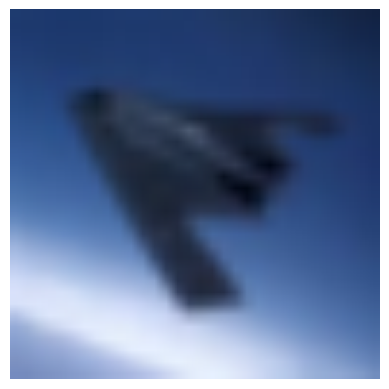

In [7]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [8]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total



### Cargar modelo pre-cargado

In [9]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


#### Exploremos el modelo

In [10]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [11]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [12]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [14]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [16]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [17]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
        #if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [18]:
lr = 5e-4
epochs = 3

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [19]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.6995857954025269, accuracy: 0.777,
Epoch: 1, costo: 0.41675159335136414, accuracy: 0.7988,
Epoch: 2, costo: 0.5297443866729736, accuracy: 0.8002,


In [21]:
accuracy(model1, test_loader)

0.7986

###Function to randomly sample image from  test dataset to test model

In [ ]:
# Define a reusable function
def display_rnd_pred(model):
    """
    Randomly samples an image from the test dataset, performs inference using
    the provided model, and displays the image along with the predicted and
    true class labels.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained PyTorch model to use for prediction.

    Returns:
    --------
    None
        The function displays the image along with the predicted and true labels.

    Description:
    ------------
    1. The model is set to evaluation mode (`model.eval()`).
    2. A random image from the test dataset is selected, and inference is
       performed to predict its class.
    3. The predicted and true class names are displayed, along with the image.
    4. The image is de-normalized and displayed

    Example:
    --------
    display_rnd_pred(modeloCNN)
    """
    model.eval()  # Set model to evaluation mode

    # Randomly sample an image from the test dataset
    sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
    image, true_label = test_loader.dataset[sample_idx]

    # Move the image to the correct device and add a batch dimension
    image = image.to(device).unsqueeze(0)  # Add batch dimension for inference

    # Perform forward pass without calculating gradients
    with torch.no_grad():
        outputs = model(image)

    # Get the predicted class
    _, predicted_label = outputs.max(1)

    # Convert prediction and true label to class names
    predicted_class = test_loader.dataset.classes[predicted_label.item()]
    true_class = test_loader.dataset.classes[true_label]

    # Display the image and the prediction
    image = torch.clamp(image, 0, 1)  # Clamp the image to valid pixel range
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    plt.title(f'Predicted Class: {predicted_class}, Actual Class: {true_class}')
    plt.show()

## Model VGG16

VGG16 is a convolutional neural network (CNN) model with 16 layers that's used to classify images:

<u>Layers</u>: VGG16 has 13 convolution layers, three fully connected layers, and a softmax for output.

<u>Training</u>: The Visual Geometry Group at the University of Oxford trained VGG16 on over 1.2 million images from the ImageNet database.

<u>Classification</u>: VGG16 can classify images into 1,000 object categories, such as animals, keyboards, mice, and pencils.

<u>Architecture</u>: VGG16 uses convolution layers with a 3x3 filter and stride 1, and maxpool layers with a 2x2 filter and stride 2.

<u>Parameters</u>: VGG16 has around 138 million parameters

<u>Images</u>: The images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. [1]

---
References:
[1] *vgg16 — Torchvision main documentation.* (s. f.). https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html



In [23]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DL/A2C/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_vgg16 = T.Compose([T.Resize(256, interpolation=InterpolationMode.BILINEAR),
                             T.CenterCrop(224),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_vgg16)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_vgg16)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_vgg16)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Load the VGG16 Model

In [24]:
#
# Load pre-trained models with the weights as defined in VGG16_Weights.IMAGENET1K_V1
model_vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 148MB/s]


In [25]:
for i, w in enumerate(model_vgg16.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64, 64, 3, 3]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128, 128, 3, 3]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256, 256, 3, 3]) True
11 torch.Size([256]) True
12 torch.Size([256, 256, 3, 3]) True
13 torch.Size([256]) True
14 torch.Size([512, 256, 3, 3]) True
15 torch.Size([512]) True
16 torch.Size([512, 512, 3, 3]) True
17 torch.Size([512]) True
18 torch.Size([512, 512, 3, 3]) True
19 torch.Size([512]) True
20 torch.Size([512, 512, 3, 3]) True
21 torch.Size([512]) True
22 torch.Size([512, 512, 3, 3]) True
23 torch.Size([512]) True
24 torch.Size([512, 512, 3, 3]) True
25 torch.Size([512]) True
26 torch.Size([4096, 25088]) True
27 torch.Size([4096]) True
28 torch.Size([4096, 4096]) True
29 torch.Size([4096]) True
30 torch.Size([1000, 4096]) True
31 torch.Size([1000]) True


In [26]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
model_vgg16_aux = nn.Sequential(*list(model_vgg16.children()))
model_vgg16_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# Avoid the calculation of gradients during backpropagation by freezeing the weights
for i, parameter in enumerate(model_vgg16_aux.parameters()):
    parameter.requires_grad = False

In [29]:
# Verify all parameters were set correctly
for i, parameter in enumerate(model_vgg16_aux.parameters()):
    print(f'{i}: Require Parameter: {parameter.requires_grad}')

0: Require Parameter: False
1: Require Parameter: False
2: Require Parameter: False
3: Require Parameter: False
4: Require Parameter: False
5: Require Parameter: False
6: Require Parameter: False
7: Require Parameter: False
8: Require Parameter: False
9: Require Parameter: False
10: Require Parameter: False
11: Require Parameter: False
12: Require Parameter: False
13: Require Parameter: False
14: Require Parameter: False
15: Require Parameter: False
16: Require Parameter: False
17: Require Parameter: False
18: Require Parameter: False
19: Require Parameter: False
20: Require Parameter: False
21: Require Parameter: False
22: Require Parameter: False
23: Require Parameter: False
24: Require Parameter: False
25: Require Parameter: False
26: Require Parameter: False
27: Require Parameter: False
28: Require Parameter: False
29: Require Parameter: False
30: Require Parameter: False
31: Require Parameter: False


In [30]:
# Extract the fully connected layers (the last Sequential block)
fc_layers = list(model_vgg16_aux.children())[-1]

In [31]:
# Convert Sequential block to a list to modify
fc_layers_list = list(fc_layers.children())
fc_layers_list

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [32]:
# Extract the original in_features
in_features = fc_layers_list[-1].in_features
# Set out_features to match the number of classes (10)
out_features = 10
fc_layers_list[-1] = nn.Linear(in_features=in_features, out_features=out_features, bias=True)
# Rebuild the Sequential block with the modified layer
new_fc_layers = nn.Sequential(*fc_layers_list)

# Replace the original fully connected layers with the modified one
model_vgg16_aux = nn.Sequential(
    *list(model_vgg16_aux.children())[:-1],
    nn.Flatten(),
    new_fc_layers
)

In [33]:
# Verify that the model has the correct number of outputs
model_vgg16_aux

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# Define learning rate and number of epochs for training
lr = 5e-4  # Learning rate: 0.0005, controls the step size during optimization
epochs = 3  # Number of epochs to train the model

# Assign the model to model_2 for consistency with other cells in the notebook
model_2 = model_vgg16_aux

# Define the optimizer
optimiser = torch.optim.Adam(
    model_2.parameters(),
    lr=lr,
    betas=(0.9, 0.999)
)

### Train the Model

In [35]:
# Train the model
train(model_2, optimiser, epochs)

Epoch: 0, costo: 0.4538711905479431, accuracy: 0.8178,
Epoch: 1, costo: 0.393755704164505, accuracy: 0.8302,
Epoch: 2, costo: 1.171825885772705, accuracy: 0.8308,


###Calculate VGG16 Model Accuracy with Test Dataset

In [ ]:
print(f'Accuracy: {accuracy(model_2, test_loader)}')

###Test model with a random image

In [ ]:
display_rnd_pred(model_2)

## Model SqueezeNet1_1

SqueezeNet 1.1 is a compact convolutional neural network (CNN) designed for image classification tasks. It achieves comparable accuracy to larger models like AlexNet while significantly reducing the number of parameters, making it ideal for scenarios where model size and computational efficiency are important

<u>Layers</u>: SqueezeNet consists of multiple Fire modules, each containing:

*  Squeeze Layers: Use 1x1 filters to reduce the number  of input channels.

*   Expand Layers: Use both 1x1 and 3x3 filters to process the compressed inputs.

*   Convolutional Layers: The network also includes standard convolutional layers for feature extraction.

*   Global Average Pooling: Instead of fully connected layers, it uses global average pooling before the final classification

<u>Training</u>: Similarly to VGG16, SqueezeNet was trained on over 1.2 million images from the ImageNet database.

<u>Classification</u>: SqueezeNet can classify images into 1,000 object categories, such as animals, keyboards, mice, and pencils.

<u>Architecture</u>: SqueezeNet replaces many 3x3 filters with 1x1 filters, drastically reducing the number of parameters.

Instead of using fully connected layers, SqueezeNet uses global average pooling at the end of the network,  reducing the number of parameters and memory requirements.

SqueezeNet uses Fire Modulesto balance the trade-off between parameter efficiency and model capacity, allowing for high performance with a small footprint.

<u>Parameters</u>: SqueezeNet has around 1.2 million parameters

<u>Images</u>: the images are resized to resize_size=[256] using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].


---

References:
*squeezenet1_1* — Torchvision main documentation. (s. f.). https://pytorch.org/vision/main/models/generated/torchvision.models.squeezenet1_1.html#torchvision.models.squeezenet1_1


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DL/A2C/cifar-10-batches-py'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64

transform_squeezenet1_1 = T.Compose([T.Resize(size=(224)),
                                     T.ToTensor(),
                                     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])
# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_squeezenet1_1)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_squeezenet1_1)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_squeezenet1_1)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

### Load pre-trained model

In [ ]:
# Load pre-trained model with the weights as defined in SqueezeNet1_1_Weights.IMAGENET1K_V1
model_squeezenet1_1 = models.squeezenet1_1(weights='IMAGENET1K_V1')

In [ ]:
#
# Check the if weights are frozen
for i, w in enumerate(model_squeezenet1_1.parameters()):
    print(i, w.shape, w.requires_grad)

In [ ]:
model_squeezenet1_1

In [ ]:
# Avoid the calculation of gradients during backpropagation by freezeing the weights
for i, parameter in enumerate(model_squeezenet1_1.parameters()):
    parameter.requires_grad = False

In [ ]:
# Verify all parameters were set correctly
for i, parameter in enumerate(model_squeezenet1_1.parameters()):
    print(f'{i}: Require Parameter: {parameter.requires_grad}')

In [ ]:
# Modify the classifier of the SqueezeNet 1.1 model to set the number of outputs
# to the number of classes in our dataset
model_squeezenet1_1.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1)),  # Set convolutional layer with 512 input channels and 10 output classes
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1))
)


In [ ]:
# Verify that the pre-trained model correctly reflects the number of classes
# in our dataset
model_squeezenet1_1

In [ ]:
# Define learning rate and number of training epochs
lr = 0.0001  # Learning rate: controls the step size for parameter updates
epochs = 3   # Number of epochs to train the model

# Assign the SqueezeNet model to model_3 for consistency across the notebook
model_3 = model_squeezenet1_1

# Define the optimizer using Adam optimization algorithm
optimiser = torch.optim.Adam(
    model_3.parameters(),
    lr=lr,
    betas=(0.9, 0.999)
)


### Train the Model

In [ ]:
# Train the model
train(model_3, optimiser, epochs)

###Calculate SqueezeNet Model Accuracy with Test Dataset

In [ ]:
print(f'Accuracy: {accuracy(model_3, test_loader)}')

###Test model with a random image

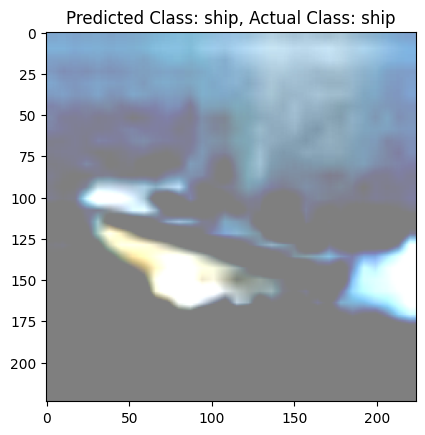

In [49]:
display_rnd_pred(model_3)

# Evaluation of Pre-trained Models on CIFAR10 Dataset

In this analysis, we evaluate the performance of three pre-trained models: VGG16, SqueezeNet, and ResNet18 on the CIFAR10 dataset. The models were trained using the provided training code, and their accuracies were calculated using the accuracy function. Below are the results and a comparison of the models' performance.

It's important to notice that the number of epochs was kept constant for all models to 3 while the learning rates where set to minimize the loss while increasing the accuracy during the 3 epochs

## VGG16 Model

### Model Architecture
```plaintext
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    ...
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(7, 7))
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    ...
    (6): Linear(in_features=4096, out_features=10, bias=True)
  )
)
```

### Training Parameters
- Learning Rate: 0.0005
- Epochs: 3

### Model Output
```plaintext
Epoch: 0, costo: 0.4538711905479431, accuracy: 0.8178
Epoch: 1, costo: 0.393755704164505, accuracy: 0.8302
Epoch: 2, costo: 1.171825885772705, accuracy: 0.8308
```

### Final Accuracy
- **Accuracy: 0.827**

## SqueezeNet Model

### Training Parameters
- Learning Rate: 0.0001
- Epochs: 3

### Model Output
```plaintext
Epoch: 0, costo: 0.43056926131248474, accuracy: 0.7308
Epoch: 1, costo: 0.8325325846672058, accuracy: 0.787
Epoch: 2, costo: 1.0455536842346191, accuracy: 0.8098
```

### Final Accuracy
- **Accuracy: 0.7955**

## ResNet18 Model

### Model Architecture
```plaintext
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    ...
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=10, bias=True)
)
```

### Training Parameters
- Learning Rate: 0.0005
- Epochs: 3

### Model Output
```plaintext
Epoch: 0, costo: 0.6995857954025269, accuracy: 0.777
Epoch: 1, costo: 0.41675159335136414, accuracy: 0.7988
Epoch: 2, costo: 0.5297443866729736, accuracy: 0.8002
```

### Final Accuracy
- **Accuracy: 0.7986**

## Comparison and Insights

- **VGG16** achieved the highest accuracy of 0.827. This model is known for its deep architecture with multiple convolutional layers, which allows it to capture complex patterns in the data.
- **SqueezeNet** had an accuracy of 0.7955. Despite its smaller size and fewer parameters, it performed reasonably well, making it a good choice for resource-constrained environments.
- **ResNet18** achieved an accuracy of 0.7986. Its residual connections help in training deeper networks by mitigating the vanishing gradient problem.

### Challenges and Insights

- **Training Time**: VGG16, being a deeper network, took longer to train compared to SqueezeNet and ResNet18.
- **Overfitting**: The VGG16 model showed signs of overfitting, as indicated by the increase in cost during the last epoch.
- **Model Complexity**: The complexity of VGG16 allows it to achieve higher accuracy, but at the cost of increased computational resources.

In conclusion, the choice of model depends on the specific requirements of the task, such as accuracy, computational resources, and training time. VGG16 is suitable for tasks where accuracy is paramount, while SqueezeNet offers a good trade-off between performance and resource efficiency.